In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
import os
import pandas as pd
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # You can change the seed number

In [10]:
# Define dataset paths
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
batch_size = 125
img_height = 256
img_width = 256

In [11]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()
])

In [12]:
# Load dataset
train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
# val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# var_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Class names
class_names = train_dataset.classes
print("Class Names:", class_names)

Class Names: ['NORMAL', 'PNEUMONIA']


In [14]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.fc1 = nn.Linear(128 * (img_height // 8) * (img_width // 8), 128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        # x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [15]:
# Initialize model
model = CNN(num_classes=len(class_names))
# model = torchvision.models.mobilenet_v3_large(pretrained=False)
# model.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(class_names))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
# Train the model
epochs = 50
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    scheduler.step()
    
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 1])
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/50 - Train Loss: 0.6940, Train Acc: 0.4930, Val Loss: 0.6925, Val Acc: 0.5000
Epoch 2/50 - Train Loss: 0.6940, Train Acc: 0.4930, Val Loss: 0.6956, Val Acc: 0.5000
Epoch 3/50 - Train Loss: 0.6933, Train Acc: 0.4930, Val Loss: 0.6901, Val Acc: 0.5000
Epoch 4/50 - Train Loss: 0.6929, Train Acc: 0.5025, Val Loss: 0.6951, Val Acc: 0.5100
Epoch 5/50 - Train Loss: 0.6823, Train Acc: 0.6010, Val Loss: 0.7392, Val Acc: 0.4850
Epoch 6/50 - Train Loss: 0.6374, Train Acc: 0.7230, Val Loss: 0.8131, Val Acc: 0.5000
Epoch 7/50 - Train Loss: 0.5979, Train Acc: 0.7775, Val Loss: 0.8355, Val Acc: 0.4900
Epoch 8/50 - Train Loss: 0.5766, Train Acc: 0.7755, Val Loss: 0.8424, Val Acc: 0.4900


In [9]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

              precision  recall  f1-score  support
NORMAL         0.483871    0.60  0.535714   100.00
PNEUMONIA      0.473684    0.36  0.409091   100.00
accuracy       0.480000    0.48  0.480000     0.48
macro avg      0.478778    0.48  0.472403   200.00
weighted avg   0.478778    0.48  0.472403   200.00


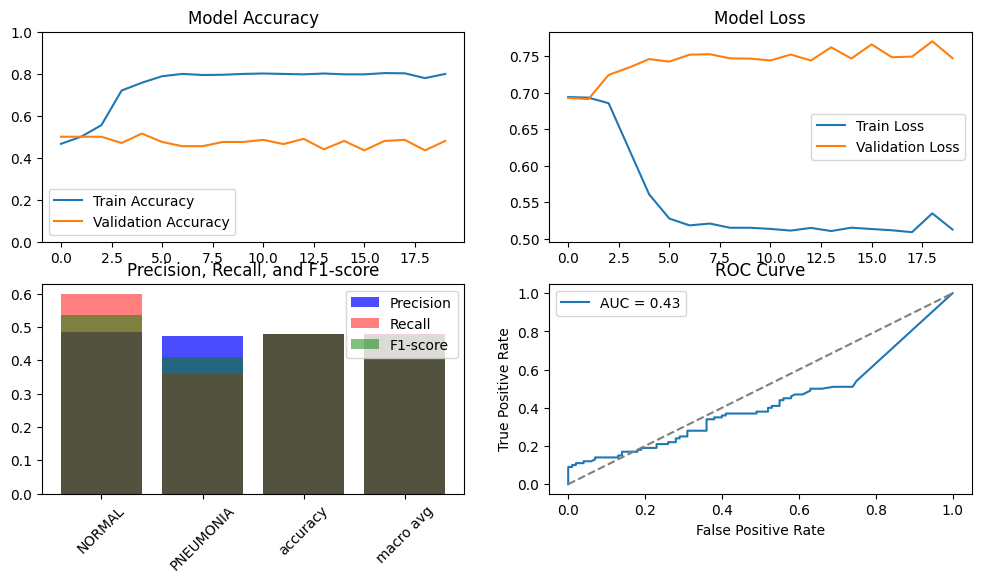

In [ ]:
# Plot metrics
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title("Model Accuracy")

plt.subplot(2, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.subplot(2, 2, 3)
# sns.barplot(x=df_report.index[:-1], y=df_report['precision'][:-1], label='Precision', color='blue')
# sns.barplot(x=df_report.index[:-1], y=df_report['recall'][:-1], label='Recall', color='red', alpha=0.5)
# sns.barplot(x=df_report.index[:-1], y=df_report['f1-score'][:-1], label='F1-score', color='green', alpha=0.5)
plt.bar(df_report.index[:-1], df_report['precision'][:-1], color='blue', alpha=0.7, label='Precision')
plt.bar(df_report.index[:-1], df_report['recall'][:-1], color='red', alpha=0.5, label='Recall')
plt.bar(df_report.index[:-1], df_report['f1-score'][:-1], color='green', alpha=0.5, label='F1-score')
plt.xticks(rotation=45)
plt.legend()
plt.title("Precision, Recall, and F1-score")

plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()


In [11]:
# Save the model
torch.save(model.state_dict(), "xray_classifier.pth")
print("Model saved as xray_classifier.pth")

Model saved as xray_classifier.pth
